In [1]:
# %pip uninstall -y amazon-braket-default-simulator
# %pip uninstall -y amazon-braket-sdk
# %pip install git+https://github.com/amazon-braket/amazon-braket-default-simulator-python.git@5b8020915bf02a4f4448b430f917c9155d61d24a
# %pip install git+https://github.com/Altanali/amazon-braket-sdk-python.git@72da648c1a2bfdc421622f5ddfd3c8ce9c7686b6

In [3]:
pip freeze | grep amazon

amazon-braket-default-simulator @ git+https://github.com/amazon-braket/amazon-braket-default-simulator-python.git@5b8020915bf02a4f4448b430f917c9155d61d24a
amazon-braket-schemas==1.22.0
amazon-braket-sdk @ git+https://github.com/Altanali/amazon-braket-sdk-python.git@72da648c1a2bfdc421622f5ddfd3c8ce9c7686b6
Note: you may need to restart the kernel to use updated packages.


In [4]:
# It should output
# amazon-braket-default-simulator @ git+https://github.com/amazon-braket/amazon-braket-default-simulator-python.git@5b8020915bf02a4f4448b430f917c9155d61d24a
# amazon-braket-schemas==1.22.0
# amazon-braket-sdk @ git+https://github.com/Altanali/amazon-braket-sdk-python.git@72da648c1a2bfdc421622f5ddfd3c8ce9c7686b6

# Ordered phases in Rydberg systems

In this example notebook, we show how one can prepare ordered phases in Rydberg systems, focusing on the 1D $Z_2$ phase and the 2D checkerboard phase. We will use an adiabatic time-evolution to prepare these many-body ground states.

## Adiabatic evolution

The adiabatic theorem of quantum mechanics states that 

>A physical system remains in its *instantaneous* eigenstate if a given perturbation is acting on it slowly enough and if there is a gap between the eigenvalue and the rest of the Hamiltonian's spectrum. (Born & Fock, 1928)

In other words, a slow-enough change in the parameters of the Hamiltonian will not induce transitions between its ground state and excited states: If the system starts in the ground state of the Hamiltonian at the beginning, it will smoothly transition into the ground state of the Hamiltonian at the end.

The adiabatic theorem plays a key role in preparing the desired many-body ground states in the Rydberg system, the Hamiltonian of which can be expressed as

\begin{align}
H(t) = \sum_{k=1}^N \frac{\Omega(t)}{2}\left(|g_k\rangle\langle r_k| + |r_k\rangle\langle g_k|\right) - \Delta_\text{global}(t){n}_k + \sum_{j=1}^{N-1}\sum_{k=j+1}^N V_{jk}{n}_j{n}_k,
\end{align}

where, for simplicity, we set the phase and the local detuning field (See notebook 00 for detailed description of this Hamiltonian) to be zero throughout this notebook. We schedule the driving amplitude $\Omega(t)$ to start from zero ($\Omega(t=0)=0$). Hence, with negative detuning ($\Delta_\text{global}(t=0)<0$), the initial state where all atoms are in the ground state ($\langle n_k\rangle =0$) is the lowest energy eigenstate of the Hamiltonian, the many-body ground state.

To arrive at a target Hamiltonian where the excited states of the atoms are favored, we ramp up the detuning $\Delta_\text{global}$ from large negative to large positive. During the ramp, we apply a large driving amplitude $\Omega$ to open an energy gap between the first excited state and the ground state. According to the adiabatic theorem, if the ramping is slow enough, the system remains in the many-body ground state throughout the evolution. At the end of the AHS program, the Rabi frequency will be turned off and since $\Delta_\text{global}>0$, all the atoms tend to stay in the Rydberg state to lower the energy of the system. However, due to the strong Rydberg interaction, only one atom can be excited to the Rydberg state within its blockade radius.

For a 1D chain of atoms, if we adjust the separation between the atoms such that only neighboring atoms are within the blockade radius, then we will arrive at a state where every second atom is excited, this is called the "$Z_2$ phase". For a 2D square array of atoms, a similar "checkerboard phase" emerges. The common feature of these phases is that the atoms are excited to the Rydberg states in an alternative pattern, complying with the blockade constraint, as shown in the figure below. In the figure, the shaded circles show *half* of the blockade radius such that sites with overlapped circles blockade each other. We show configurations, with black and white sites represent Rydberg and ground state atoms respectively, that comply with the blockade constraint. 

![Blockade_examples.png](Blockade_examples.png)

We will realize these phases in this notebook. To begin, we import the necessary packages.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from braket.ahs.atom_arrangement import AtomArrangement

from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.ahs.driving_field import DrivingField

from ahs_utils import show_register, show_global_drive, show_final_avg_density

from braket.devices import LocalSimulator

## 1D $Z_2$ phase 

Here we consider a 1D chain of 9 atoms with neighboring atoms separated by $6.1\mu m$. The setup of the system can be generated as follows

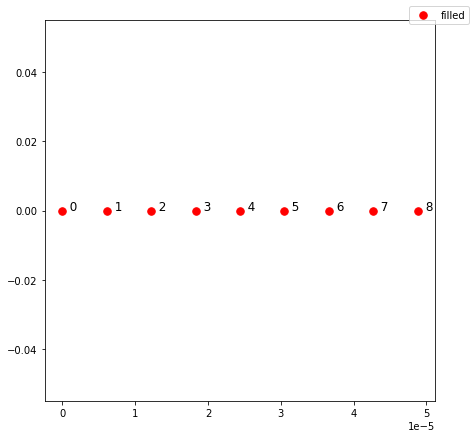

In [6]:
register = AtomArrangement()
separation = 6.1e-6  # in meters 
num_atoms = 9

for k in range(num_atoms):
    register.add([k * separation, 0])
    
show_register(register)

In order to prepare the $Z_2$ ordered state for the atomic chain, we shall design an AHS program that drives the system adiabatically. As described above, we start from $\Omega(t=0)=0$ with $\Delta(t=0)<0$, followed by turning on $\Omega(t)$ and ramping up $\Delta(t)$. We will turn off the driving amplitude at the end of the program. This program can be specified as follows.

In [7]:
time_points = [0, 2.5e-7, 2.75e-6, 3e-6]
amplitude_min = 0
amplitude_max = 1.57e7  # rad / s

detuning_min = -5.5e7  # rad / s
detuning_max = 5.5e7  # rad / s

amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]  # piecewise linear
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]  # piecewise linear
phase_values = [0, 0, 0, 0]  # piecewise constant


drive = DrivingField.from_lists(time_points, amplitude_values, detuning_values, phase_values)

We can plot the waveforms of these driving fields to make sure that they are correctly specified.

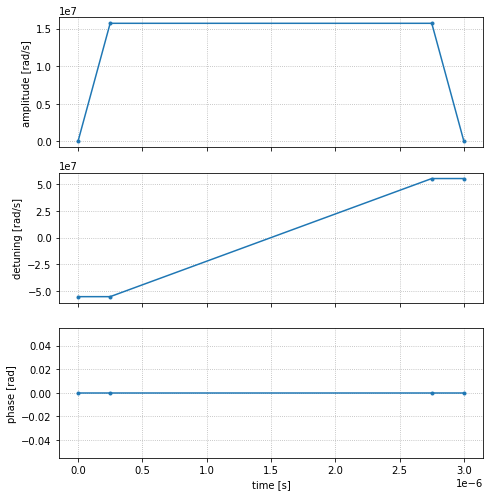

In [8]:
show_global_drive(drive);

Finally, we construct out AHS program from the atomic registers, and the Hamiltonian defined above. 

In [9]:
ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)

# Device emulation

In [10]:
from braket.aws import AwsDevice
from braket.devices import Devices
qpu = AwsDevice(Devices.QuEra.Aquila)

In [11]:
qpu.validate(ahs_program)

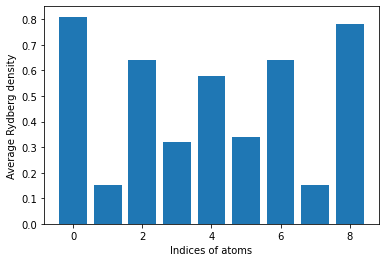

CPU times: user 289 ms, sys: 407 ms, total: 696 ms
Wall time: 13.9 s


In [12]:
%%time 
result_1D_emu = qpu.emulate(ahs_program, shots=100).result()
show_final_avg_density(result_1D_emu)

## 2D checkerboard phase 

In two dimension, Rydberg system can exhibit the checkerboard phase, which is analogous to the $Z_2$ phase in 1D. For simplicity, here we create a $3\times 3$ square lattice.

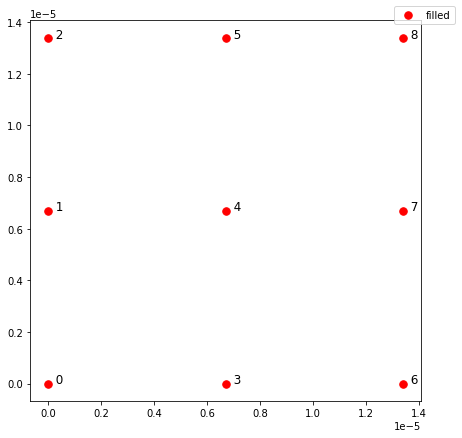

In [13]:
register_2D = AtomArrangement()
separation = 6.7e-6  # in meters 

for k in range(3):
    for l in range(3):
        register_2D.add((k * separation, l * separation))

show_register(register_2D)

We will use the same driving field as the one for generating the $Z_2$ phase. We then assemble the 2D array with the driving field, and run the AHS program on the local simulator. 

In [14]:
ahs_program_2D = AnalogHamiltonianSimulation(
    register=register_2D, 
    hamiltonian=drive
)

In [15]:
qpu.validate(ahs_program_2D)

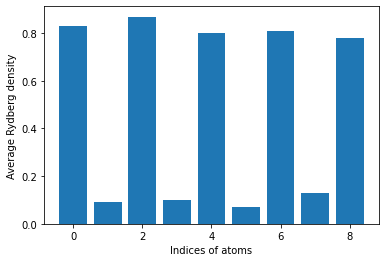

CPU times: user 226 ms, sys: 446 ms, total: 673 ms
Wall time: 12.9 s


In [16]:
%%time 
result_2D_emu = qpu.emulate(ahs_program_2D, shots=100).result()
show_final_avg_density(result_2D_emu)